<br>
<br><a id="top"></a>
<form action="/action_page.php">
  <fieldset>
    
   <div class="card">
  <h1 class="card-header" align="center">Modeling Student Posttest Performance</h1>
  </div>
   </form>

## Summary
<hr>

### Current Practice
First, we explored a single baseline regression model to understand how well the school system currently predicts scores using only pretest data. ~90% of the variation observed in posttest scores can be explained as a function of pretest scores. The residuals for this model were normally distributed, and the level of error in this model is a little less than  ½ a grade, as grades are given on a scale of 0-100 where 90-100 is an A, 80-90 is a B and so on. As such, it seems that pretesting provides a strong predictor student performance by itself. Code for this model is in the [EDA notebook]('code/EDA.ipynb').<br><br>
![lecture hall](../images/baseline.png)<br><br>

### Predicting Student Performance as a Function of Environmental Variables <br>
    
![predictors](../images/predictors.png)<br><br> 
    
In light of recent budget cuts, the school system is wondering how well they can predict posttest performance without using pretest data, which is expensive to collect. 

To build the environmental predictor model, we removed pretest data and created dummy variables for categorical values, initially using all available dummied and continuous predictors. The initial model had an R2 value of .86 and an RMSE of 6.34. After checking the residuals and running some cross-validation testing it became clear that the model was overfit. <br>

Using recursive feature elimination we improved this performance of the model to have an **R-squared value of .85 and RMSE of 5.71**. Though these two metrics decreased, we saw some improvement cross validation scores, indicating some of the overfitting had been dealt with. <br>

Depending on the school system’s use for these predictions, I was particularly surprised to see that estimating student performance as a target of environmental predictors alone can be fairly successful. *While this model explains 85% of the variance in the data as opposed to the 90% achieved in the pretest model, and the RMSE is 1.4 grade points higher, I still expect this could be a useful model for predicting student performance.*
[Go to environmental model.](#environmental)
<br><br>

### Improving Current Practice Utilizing Multiple Linear Regression
To understand how we might improve on the existing practice of predicting scores using only pretest data, we then created a model using both pretest data and environmental data as predictors for the target variable, posttest score. 

Much like in the environmental factors model, we ran into some over fitting and and treated it mostly using feature elimination. Notably, in the environmental factors model number of students in each class improved performance by exhibiting a delta of .25 for every unit of the change in score, while in this model the inclusion of class size detracted from the overall performance and was removed.

Further exploration revealed a relationship that I failed to detect earlier in the analysis. There was some multicollinearity occurring between school and class size. This does stand to reason - I treated for the redundancy between school and school setting (rural, suburban or urban) in this dataset but as we saw earlier in this presentation, there was another relationship between school and # of students, even without the school setting information. In short, school setting, type, and number of students can be well explained by the school variable alone.

This model performs well in the prediction of posttest scores for students. The **RMSE is approximately a third of a grade, and 95% of the variance in the data is explained by this model**.
[Go to all predictors model.](#allpreds)



In [2]:
#import the appropriate tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.figure_factory import create_scatterplotmatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
#import the data
df = pd.read_csv('../data/test_scores 2.csv')
#list of schools
schools = list(set(df.school))
#list to hold school dataframes
school_dfs=[]
#create one dataframe per school and drop student id col
for sc in schools:
    sc = df[df['school'] == sc]
    sc.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
    school_dfs.append(sc)
school_dfs[5].columns

Index(['school', 'teaching_method', 'n_student', 'lunch', 'pretest',
       'posttest'],
      dtype='object')

> **Comments:** By school, certain types of variables become irrelevant. This may be where some of the collinearity in my first model was coming from. Schools do not have mixed school_setting or school_type. It seems like I'm dealing with two strata of data. School level data and class level data. Seeing this, I think a two-table database would be a better data structure for this data. There is a lot of redundancy.

In [6]:
#create dummies for categorical variables
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [7]:
# #drop og columns
df.drop(cols_to_fix,axis=1,inplace=True)
# df = df.drop(['student_id'],axis=1)

In [8]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})
df.head()

,n_student,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,...,school_UAGPU,school_UKPGS,school_UUUQX,school_VHDHF,school_VKWQH,school_VVTVA,school_ZMNYA,school_ZOWMK,teaching_method_Standard,free_lunch
0,20.0,62.0,72.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20.0,66.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,61.0,77.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Environmental Predictors Model <a id="environmental"></a>

In [9]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest','pretest'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     420.5
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:44:30   Log-Likelihood:                -6744.2
No. Observations:                2133   AIC:                         1.354e+04
Df Residuals:                    2107   BIC:                         1.369e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   72.1482      1.553     46.454      0.000      69.102      75.194
n_student                    0.2591      0.060      4.321      0.000       0.141       0.377
school_CCAAW                 5.0278      1.095      4.591      0.000       2.880       7.175
school_CIMBB                 4.6258      1.127      4.105      0.000       2.416       6.836
school_CUQAM                -8.3934      1.125     -7.462      0.000     -10.599      -6.187
school_DNQDD                -6.2830      1.107     -5.678      0.000      -8.453      -4.113
school_FBUMG                 3.2337      1.307      2.474      0.013       0.670       5.797
school_GJJHK                -5.8203      1.121     -5.194      0.000      -8.018      -3.623
school_GOKXL                -8.2417      1.216     -6.775      0.000     -10.627      -5.856
school_GOOBU               -21.3221      1.136    -18.773      0.000     -23.549     -19.095
school_IDGFP                13.7049      1.086     12.619      0.000      11.575      15.835
school_KFZMY               -18.7164      1.297    -14.434      0.000     -21.259     -16.174
school_KZKKE               -20.6429      1.134    -18.197      0.000     -22.868     -18.418
school_LAYPA                 0.6054      1.183      0.512      0.609      -1.715       2.926
school_OJOBU                -4.4621      1.105     -4.039      0.000      -6.628      -2.296
school_QOQTS                -9.9118      1.055     -9.395      0.000     -11.981      -7.843
school_UAGPU                 0.1498      1.092      0.137      0.891      -1.991       2.291
school_UKPGS                16.6039      1.043     15.925      0.000      14.559      18.649
school_UUUQX                 6.5530      1.122      5.841      0.000       4.353       8.753
school_VHDHF                -4.9289      1.292     -3.815      0.000      -7.462      -2.396
school_VKWQH                -8.6645      1.074     -8.070      0.000     -10.770      -6.559
school_VVTVA               -24.2480      1.232    -19.690      0.000     -26.663     -21.833
school_ZMNYA                 5.7950      1.161      4.992      0.000       3.518       8.072
school_ZOWMK               -19.3290      1.227    -15.747      0.000     -21.736     -16.922
teaching_method_Standard    -5.9896      0.291    -20.572      0.000      -6.561      -5.419
free_lunch                  -3.3684      0.426     -7.899      0.000      -4.205      -2.532
==============================================================================
Omnibus:                        8.246   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.667
Skew:                           0.044   Prob(JB):                       0.0357
Kurtosis:                       2.741   Cond. No.                     

In [84]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 5.7139100936234035
R**2 Score: 0.8330315472545172


> **Comments:** The Jarque-Bera result indicates some of the error might not be normally distributed...the p-value of 0.13 is slightly too high to reject the null hypothesis for normality. The level of skew and kurtosis are in favor of normality.I suspect dropping some of the classroom variables will cause us to see an improvement in model performance.

# Cross Validation

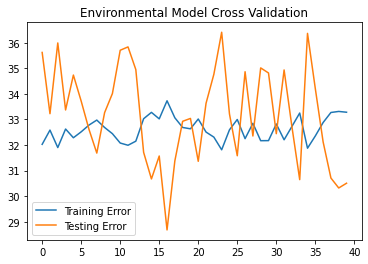

In [14]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.title('Environmental Model Cross Validation')
plt.legend();

In [19]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 5.713884580742654
R**2 Score: 0.8330330382953786


### Check the Cross Validation Score

In [20]:
cv10 = cross_val_score(linreg,X,y,cv=10,scoring='neg_mean_squared_error')
print((-cv10)**0.5)
print(np.mean(cv10))

[ 9.02480262  8.65693032  7.40177929 18.69403892 11.50153072  7.80825356
  8.488635    7.52514722 10.57855581 16.33536419]
-126.13316962929939


<div class="alert alert-warning" role="alert">
  Yikes! These results have a pretty large spread.
</div>

# Environmental Model Again

In [116]:
#import the data
df = pd.read_csv('../data/test_scores 2.csv')

#create dummies for categorical variables and drop columns that detract from model performance
#ran this many times. the final adjustment that allowed a gain in model performance 
# was treating the classroom size as a categorical variable
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch','n_student']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)
    
#drop un-dummified categorical columns
df.drop(cols_to_fix,axis=1,inplace=True)

#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)

#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})

#define target & predictors
y= df[['posttest']]
X = df.drop(['posttest','pretest','school_UAGPU'], axis=1)

df.head()

,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,school_GOOBU,...,n_student_22.0,n_student_23.0,n_student_24.0,n_student_25.0,n_student_26.0,n_student_27.0,n_student_28.0,n_student_29.0,n_student_30.0,n_student_31.0
0,62.0,72.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66.0,79.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64.0,76.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61.0,77.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,64.0,76.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Test: 0, R2: 0.8640942845449823, RMSE: 5.135435967387828
Test: 1, R2: 0.8592874827953079, RMSE: 5.194141184872677
Test: 2, R2: 0.8619727892537854, RMSE: 5.187896910607652
Test: 3, R2: 0.8548792433688522, RMSE: 5.216368684588244
Test: 4, R2: 0.8610434709802368, RMSE: 5.1611962043399755
Test: 5, R2: 0.8608460829993525, RMSE: 5.196846156235997
Test: 6, R2: 0.8640296003799178, RMSE: 5.164124211504413
Test: 7, R2: 0.8608618046784801, RMSE: 5.205121989658213
Test: 8, R2: 0.8646707983188925, RMSE: 5.164536970777278
Test: 9, R2: 0.8544135616656198, RMSE: 5.202886567732105
Test: 10, R2: 0.8551935487903339, RMSE: 5.256693168982817
Test: 11, R2: 0.8543960622765063, RMSE: 5.266467355182217
Test: 12, R2: 0.8556346469703774, RMSE: 5.196446432598484
Test: 13, R2: 0.8568901254129728, RMSE: 5.209614654163512
Test: 14, R2: 0.8496454678898199, RMSE: 5.254961915903487
Test: 15, R2: 0.852991673558993, RMSE: 5.268103235532053
Test: 16, R2: 0.8563550100294639, RMSE: 5.199342305243208
Test: 17, R2: 0.85684421

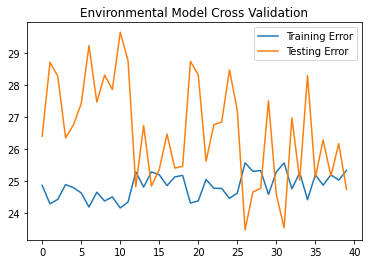

In [117]:
#Run 40 different linear regressions with different train/test splits and view the cross val scores
linreg = LinearRegression()
num = 40
train_err = []
test_err = []

#instantiate scaler object
scale = MinMaxScaler()

#run the cross validations
for i in range(num):
    #create train/test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #scale predictors
    X_train_transformed = scale.fit_transform(X_train)
    X_test_transformed = scale.transform(X_test)
    linreg.fit(X_train_transformed, y_train)
    y_hat_train = linreg.predict(X_train_transformed)
    y_hat_test = linreg.predict(X_test_transformed)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    reg_q = linreg.fit(X_test_transformed, y_test)
#     print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
    print('Test: {}, R2: {}, RMSE: {}'.format(i,linreg.score(X_train_transformed, y_train),np.sqrt(mean_squared_error(y, reg_q.predict(X)))))
print('\nOver 40 Model Builds, Averages are: \nR Squared: {}, RMSE: {}'.format(sum(r2)/len(r2),sum(rmse)/len(rmse)))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.title('Environmental Model Cross Validation')
plt.legend();

# Regularized Environmental

Tested methods to regularize the coefficients to see if that would have an effect on the overfitting we see above. LASSO made the model perform incredibly poorly. Initially the model didn't show as much overfitting as it did just plain old error. When I made the transition to categorical classroom size the error diminished but the overfitting reappeared, which led to experimentation with regularization methods.

## Ridge

In [119]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression

#import the data
df = pd.read_csv('../data/test_scores 2.csv')

#create dummies for categorical variables and drop columns that detract from model performance
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch','n_student']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

#drop un-dummified categorical columns
df.drop(cols_to_fix,axis=1,inplace=True)

#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)

#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})

#define target & predictors
y= df[['posttest']]
X = df.drop(['posttest','pretest','school_UAGPU'], axis=1)

Test: 0, R2: 0.853089755014066, RMSE: 5.324110219181046
Test: 1, R2: 0.8537081183243452, RMSE: 5.258879296716511
Test: 2, R2: 0.8494432873995397, RMSE: 5.339320362005184
Test: 3, R2: 0.8529946584267141, RMSE: 5.319539510951745
Test: 4, R2: 0.8570511118849318, RMSE: 5.262076304273941
Test: 5, R2: 0.8382778776656536, RMSE: 5.464075752388915
Test: 6, R2: 0.847351832245434, RMSE: 5.33470712667862
Test: 7, R2: 0.8494671877573736, RMSE: 5.278598026146402
Test: 8, R2: 0.8506187866124886, RMSE: 5.298418705558635
Test: 9, R2: 0.8541548630426425, RMSE: 5.242754309806865
Test: 10, R2: 0.8584668077915935, RMSE: 5.229901655825951
Test: 11, R2: 0.8494812615314979, RMSE: 5.282725615545691
Test: 12, R2: 0.8485349045382957, RMSE: 5.343629796874948
Test: 13, R2: 0.858527799035921, RMSE: 5.237546969423264
Test: 14, R2: 0.8478697154694554, RMSE: 5.3245064176359795
Test: 15, R2: 0.8587268711490632, RMSE: 5.293152954852315
Test: 16, R2: 0.8493161485395779, RMSE: 5.29875729274665
Test: 17, R2: 0.842877993670

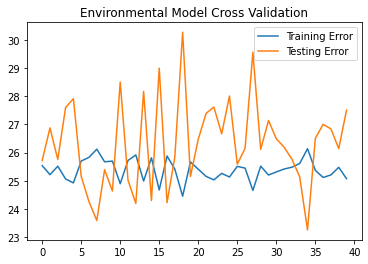

In [123]:
#Run 40 different linear regressions with different train/test splits and view the cross val scores
ridge = Ridge(alpha=0.80)
num = 40
train_err = []
test_err = []

#instantiate scaler object
scale = MinMaxScaler()

#run the cross validations
for i in range(num):
    #create train/test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #scale predictors
    X_train_transformed = scale.fit_transform(X_train)
    X_test_transformed = scale.transform(X_test)
    ridge.fit(X_train_transformed, y_train)
    y_hat_train = ridge.predict(X_train_transformed)
    y_hat_test = ridge.predict(X_test_transformed)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    reg_q = ridge.fit(X_test_transformed, y_test)
    r2 = []
    rmse = []
    r2.append(ridge.score(X_train_transformed, y_train))
    rmse.append(np.sqrt(mean_squared_error(y, reg_q.predict(X))))
    print('Test: {}, R2: {}, RMSE: {}'.format(i,ridge.score(X_train_transformed, y_train),
                                              np.sqrt(mean_squared_error(y, reg_q.predict(X)))))

print('\nOver 40 Model Builds, Averages are: \nR Squared: {}, RMSE: {}'.format(sum(r2)/len(r2),sum(rmse)/len(rmse)))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.title('Environmental Model Cross Validation')
plt.legend();

> **Comments:** Awesome. The regularization seems to have addressed some of the overfitting. I tried a handful of values for alpha, and .80 gave a nice balance between predictive performance and overfitting. 

# Model: Pretest + Environmental Predictors <a id="allpreds"></a>

In [24]:
#import the data
df = pd.read_csv('test_scores 2.csv')

In [25]:
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [26]:
df.drop(cols_to_fix,axis=1,inplace=True)

In [27]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})
df.head()

,n_student,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,...,school_UAGPU,school_UKPGS,school_UUUQX,school_VHDHF,school_VKWQH,school_VVTVA,school_ZMNYA,school_ZOWMK,teaching_method_Standard,free_lunch
0,20.0,62.0,72.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20.0,66.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,61.0,77.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [28]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1544.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:48:16   Log-Likelihood:                -5454.9
No. Observations:                2133   AIC:                         1.096e+04
Df Residuals:                    2106   BIC:                         1.112e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   26.5690      1.068     24.881      0.000      24.475      28.663
n_student                    0.0095      0.033      0.288      0.773      -0.055       0.074
pretest                      0.8261      0.012     70.347      0.000       0.803       0.849
school_CCAAW                 0.4308      0.602      0.716      0.474      -0.750       1.612
school_CIMBB                 1.1030      0.618      1.785      0.074      -0.109       2.315
school_CUQAM                -1.0563      0.624     -1.694      0.090      -2.279       0.166
school_DNQDD                -1.1531      0.609     -1.893      0.058      -2.348       0.041
school_FBUMG                 0.0523      0.716      0.073      0.942      -1.351       1.456
school_GJJHK                -0.6447      0.617     -1.045      0.296      -1.854       0.565
school_GOKXL                -1.5971      0.672     -2.378      0.017      -2.914      -0.280
school_GOOBU                -3.2726      0.672     -4.872      0.000      -4.590      -1.955
school_IDGFP                 1.9440      0.617      3.153      0.002       0.735       3.153
school_KFZMY                -3.5304      0.741     -4.766      0.000      -4.983      -2.078
school_KZKKE                -3.1211      0.668     -4.671      0.000      -4.431      -1.811
school_LAYPA                -0.2538      0.647     -0.392      0.695      -1.522       1.015
school_OJOBU                -0.5390      0.606     -0.889      0.374      -1.728       0.650
school_QOQTS                -1.6687      0.588     -2.836      0.005      -2.823      -0.515
school_UAGPU                -0.3963      0.597     -0.664      0.507      -1.566       0.774
school_UKPGS                 2.7856      0.603      4.622      0.000       1.604       3.968
school_UUUQX                 0.6203      0.619      1.002      0.316      -0.593       1.834
school_VHDHF                -1.0763      0.708     -1.520      0.129      -2.465       0.312
school_VKWQH                -1.3372      0.596     -2.244      0.025      -2.506      -0.169
school_VVTVA                -4.0763      0.732     -5.572      0.000      -5.511      -2.642
school_ZMNYA                 0.5183      0.639      0.811      0.417      -0.735       1.771
school_ZOWMK                -3.3562      0.708     -4.739      0.000      -4.745      -1.967
teaching_method_Standard    -6.0371      0.159    -37.942      0.000      -6.349      -5.725
free_lunch                  -0.4857      0.237     -2.053      0.040      -0.950      -0.022
==============================================================================
Omnibus:                        4.339   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                4.924
Skew:                           0.012   Prob(JB):       

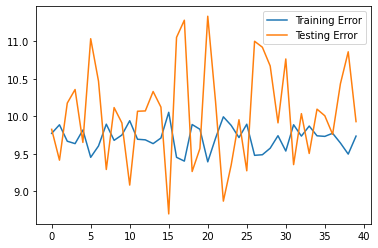

In [29]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [30]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 3.12193179057927
R**2 Score: 0.9501558220594473


In [31]:
cv5 = cross_val_score(linreg,X,y,cv=5,scoring='neg_mean_squared_error')
print((-cv5)**0.5)
print(np.mean(cv5))

[3.37870845 3.59620662 3.87388062 3.49306372 4.86502474]
-15.045056763980076


### Dropping some features and trying again

In [154]:
#import the data
df = pd.read_csv('../data/test_scores 2.csv')

In [155]:
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch','n_student']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [156]:
df.drop(cols_to_fix,axis=1,inplace=True)

In [186]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch","n_student_22.0":"n_student_22",
                      "n_student_21.0":"n_student_21","n_student_18.0":"n_student_18","n_student_17.0":"n_student_17",
                     "n_student_16.0":"n_student_16","n_student_30.0":"n_student_30","n_student_19.0":"n_student_19",
                     "n_student_15.0":"n_student_15","n_student_20.0":"n_student_20","n_student_25.0":"n_student_25",
                     "n_student_23.0":"n_student_23","n_student_24.0":"n_student_24","n_student_26.0":"n_student_26",
                     "n_student_27.0":"n_student_27","n_student_28.0":"n_student_28","n_student_29.0":"n_student_29",
                     "n_student_31.0":"n_student_31","n_student_32.0":"n_student_32"})

In [189]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest','school_FBUMG','school_CCAAW','school_LAYPA','school_OJOBU',
                      'school_UAGPU','school_GJJHK','school_ZMNYA','school_UUUQX','school_VHDHF'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()


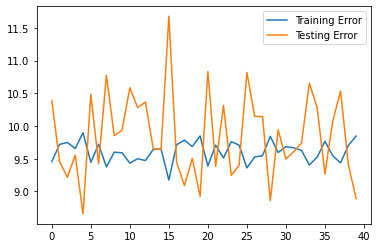

In [190]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [191]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))
cv = cross_val_score(linreg,X,y,cv=10,scoring='neg_mean_squared_error')
print('Cross Validation Scores:',(-cv)**0.5)
print('Cross Validation Mean Squared:',np.mean(cv))

RMSE: 3.1010723327831347
R**2 Score: 0.9508196732244101
Cross Validation Scores: [3.04646075 3.58790561 3.23750809 3.90698502 3.71517557 3.21911702
 3.28813256 3.57599349 3.33002718 3.33321374]
Cross Validation Mean Squared: -11.78641643769678


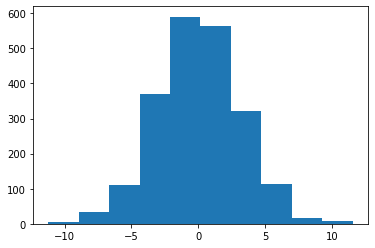

In [192]:
plt.hist(model.resid);

## Summary

This model performs well in the prediction of posttest scores for students. The **RMSE is approximately a third of a grade, and 95% of the variance in the data is explained by this model**.

[Go to top.](#top)